In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

In [3]:
# 1. Load the "Golden Record"
df = pd.read_csv('clean_data.csv')

In [4]:
# Convert dates again (CSV loses date formatting)
df['order_purchase_timestamp'] = pd.to_datetime(df['order_purchase_timestamp'])

In [5]:
# 2. Set the "Analysis Date"
# We act as if we are analyzing this the day after the last data point.
# If we use "today" (2025), Recency will be huge (2000+ days) for everyone.
max_date = df['order_purchase_timestamp'].max() + pd.Timedelta(days=1)
print(f"Analysis Date set to: {max_date}")

Analysis Date set to: 2018-08-30 15:00:37


In [6]:
# 3. Calculate RFM + Strategy Metrics
# We group by the HUMAN ID (customer_unique_id)
rfm = df.groupby('customer_unique_id').agg({
    'order_purchase_timestamp': lambda x: (max_date - x.max()).days,  # Recency
    'order_id': 'count',                                              # Frequency
    'total_order_value': 'sum',                                       # Monetary
    'review_score': 'mean',                                           # Satisfaction
    'product_category_name': lambda x: x.mode()[0] if not x.mode().empty else 'unknown' # Favorite Category
}).reset_index()

In [7]:
# 4. Rename Columns for Clarity
rfm.columns = ['customer_unique_id', 'Recency', 'Frequency', 'Monetary', 'Avg_Review_Score', 'Favorite_Category']

In [9]:
# 5. Outlier Detection (Sanity Check)
print(f"\nSummary Stats:\n{rfm.describe()}")


Summary Stats:
            Recency     Frequency      Monetary  Avg_Review_Score
count  93358.000000  93358.000000  93358.000000      93358.000000
mean     237.941773      1.033420    165.168210          4.126180
std      152.591453      0.209097    226.292101          1.319076
min        1.000000      1.000000      9.590000          0.000000
25%      114.000000      1.000000     63.010000          4.000000
50%      219.000000      1.000000    107.780000          5.000000
75%      346.000000      1.000000    182.510000          5.000000
max      714.000000     15.000000  13664.080000          5.000000


In [11]:
# 6. Save the RFM Table
rfm.to_csv('rfm_table.csv', index=False)
print("Saved RFM Table to 'data/processed/rfm_table.csv'")

Saved RFM Table to 'data/processed/rfm_table.csv'


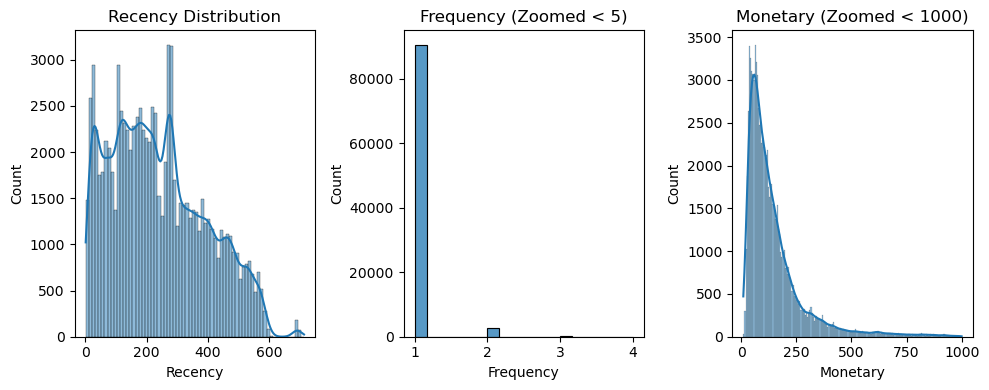

In [12]:
# --- Visual Check ---
# Let's see that skew you noticed (Frequency)
plt.figure(figsize=(10, 4))
plt.subplot(1, 3, 1)
sns.histplot(rfm['Recency'], kde=True); plt.title('Recency Distribution')
plt.subplot(1, 3, 2)
sns.histplot(rfm[rfm['Frequency'] < 5]['Frequency'], kde=False); plt.title('Frequency (Zoomed < 5)')
plt.subplot(1, 3, 3)
sns.histplot(rfm[rfm['Monetary'] < 1000]['Monetary'], kde=True); plt.title('Monetary (Zoomed < 1000)')
plt.tight_layout()
plt.show()